In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# TEAM NOTE:
# Before running any code, make sure to:
# 1. Mount your Google Drive
# 2. Verify BASE_PATH is correct for your Drive



In [4]:
# ===============================
#   SETUP CELL - Run this first
# ===============================

# Base path for project
BASE_PATH = '/content/drive/MyDrive/Land_Classification_Project/dataset /EuroSAT_RGB/EuroSAT_RGB'

if os.path.exists(BASE_PATH):
    print("✅ Drive connected and project path found!")
else:
    print("⚠️ Please check the project folder path.")


✅ Drive connected and project path found!


In [5]:
import os

path = '/content/drive/MyDrive/Land_Classification_Project/dataset /EuroSAT_RGB/EuroSAT_RGB'
print(os.path.exists(path))


True


In [6]:
base_path = '/content/drive/MyDrive/Land_Classification_Project/dataset /EuroSAT_RGB/EuroSAT_RGB'

classes = os.listdir(base_path)
print("Classes:", classes)


Classes: ['SeaLake', 'River', 'Residential', 'PermanentCrop', 'Pasture', 'Industrial', 'Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Highway']


In [7]:

base_path = '/content/drive/MyDrive/Land_Classification_Project/dataset /EuroSAT_RGB/EuroSAT_RGB'

classes = os.listdir(base_path)
print("Classes:", classes)

Classes: ['SeaLake', 'River', 'Residential', 'PermanentCrop', 'Pasture', 'Industrial', 'Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Highway']


In [8]:


IMG_SIZE = (64, 64)
X, y = [], []

for idx, cls in enumerate(classes):
    folder = os.path.join(base_path, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(idx)

X = np.array(X) / 255.0  # Normalize
y = to_categorical(y, num_classes=len(classes))


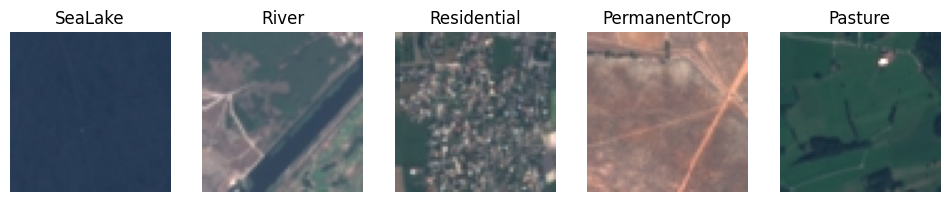

In [9]:
base_path = base_path
classes = os.listdir(base_path)

plt.figure(figsize=(12,8))
for i, cls in enumerate(classes[:5]):  # اعرض أول 5 classes
    img_path = os.path.join(base_path, cls, random.choice(os.listdir(os.path.join(base_path, cls))))
    img = plt.imread(img_path)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()


In [10]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


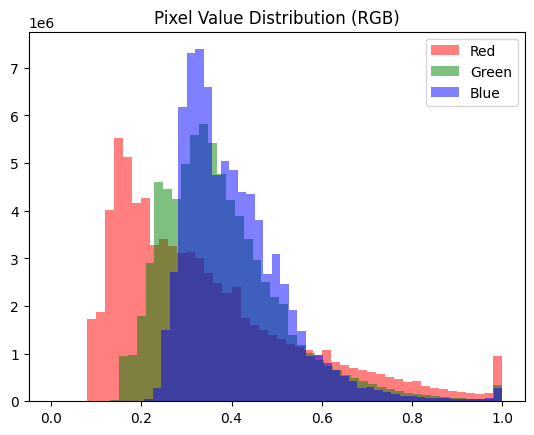

In [12]:
plt.hist(X_train[:,:,:,0].ravel(), bins=50, color='r', alpha=0.5, label='Red')
plt.hist(X_train[:,:,:,1].ravel(), bins=50, color='g', alpha=0.5, label='Green')
plt.hist(X_train[:,:,:,2].ravel(), bins=50, color='b', alpha=0.5, label='Blue')
plt.legend()
plt.title('Pixel Value Distribution (RGB)')
plt.show()


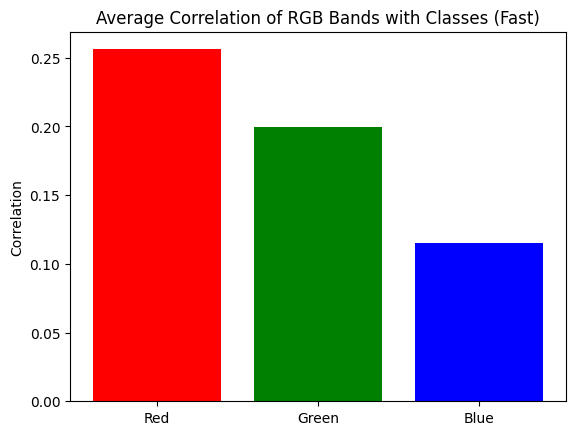

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

R_mean = X[:,:,:,0].mean(axis=(1,2))
G_mean = X[:,:,:,1].mean(axis=(1,2))
B_mean = X[:,:,:,2].mean(axis=(1,2))

df_fast = pd.DataFrame({
    'Red': R_mean,
    'Green': G_mean,
    'Blue': B_mean,
    'class': np.argmax(y, axis=1)
})

correlations = df_fast.corr()['class'][:-1]

plt.bar(correlations.index, correlations.values, color=['r','g','b'])
plt.title("Average Correlation of RGB Bands with Classes (Fast)")
plt.ylabel("Correlation")
plt.show()


✅ PCA reduced shape: (27000, 50)


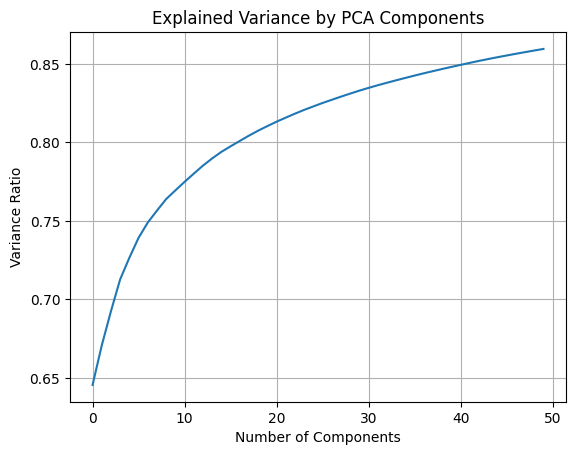

In [14]:

X_reshaped = X.reshape(X.shape[0], -1)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_reshaped)

print("✅ PCA reduced shape:", X_pca.shape)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Variance Ratio")
plt.grid()
plt.show()



In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,442 (6.20 MB)

 Trainable params: 1,626,442 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val)
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 127s 211ms/step - accuracy: 0.3903 - loss: 1.5991 - val_accuracy: 0.5822 - val_loss: 1.1200
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 124s 209ms/step - accuracy: 0.6355 - loss: 1.0133 - val_accuracy: 0.7141 - val_loss: 0.8123
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 124s 210ms/step - accuracy: 0.7105 - loss: 0.8042 - val_accuracy: 0.7323 - val_loss: 0.7547
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 128s 216ms/step - accuracy: 0.7318 - loss: 0.7363 - val_accuracy: 0.7289 - val_loss: 0.7932
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 124s 210ms/step - accuracy: 0.7505 - loss: 0.6999 - val_accuracy: 0.7560 - val_loss: 0.7193
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 122s 206ms/step - accuracy: 0.7845 - loss: 0.6085 - val_accuracy: 0.6948 - val_loss: 0.8729
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 127s 215ms/step - accuracy: 0.7890 - loss: 0.5821 - val_accuracy: 0.8116 - val_loss: 0.5513
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 123s 208ms/step - accuracy: 0.7915 -

In [17]:


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))
base_model.trainable = False

model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(classes), activation='softmax')
])

model_tl.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_tl.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step


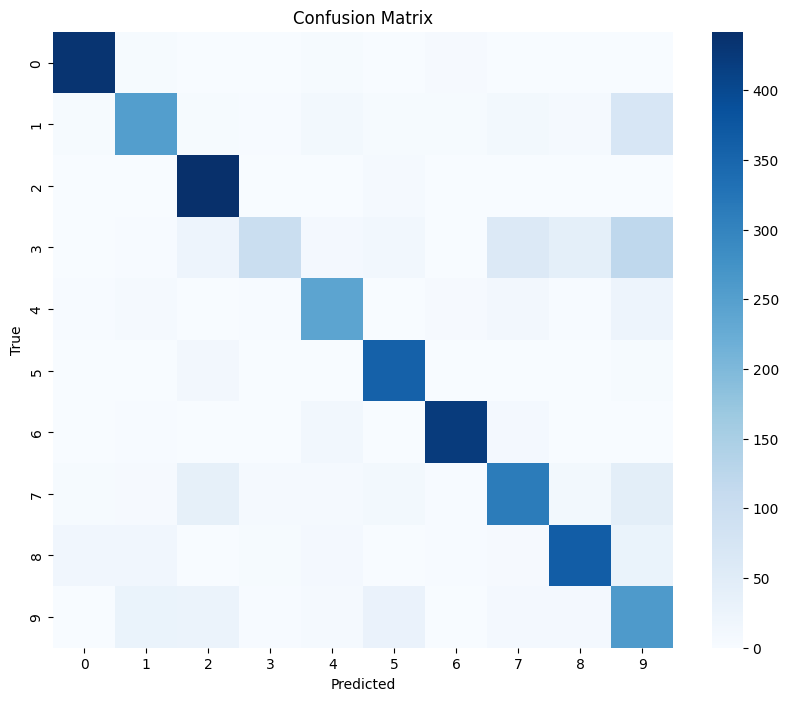

In [18]:


y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


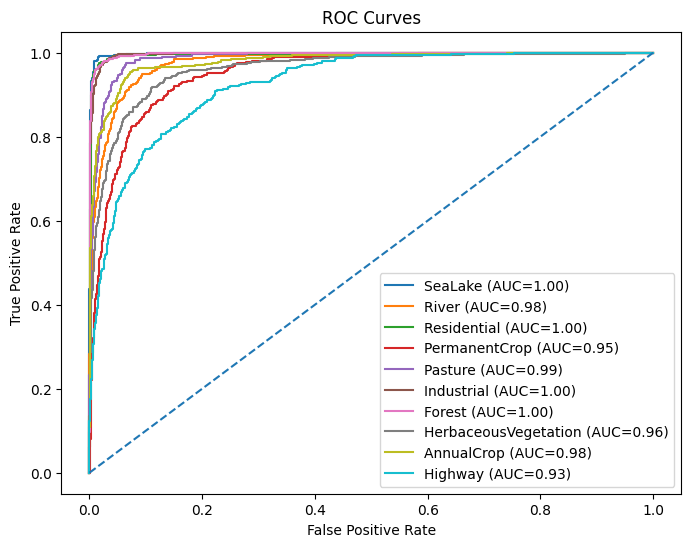

In [19]:
y_test_bin = label_binarize(y_true, classes=list(range(len(classes))))
y_pred_bin = y_pred

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


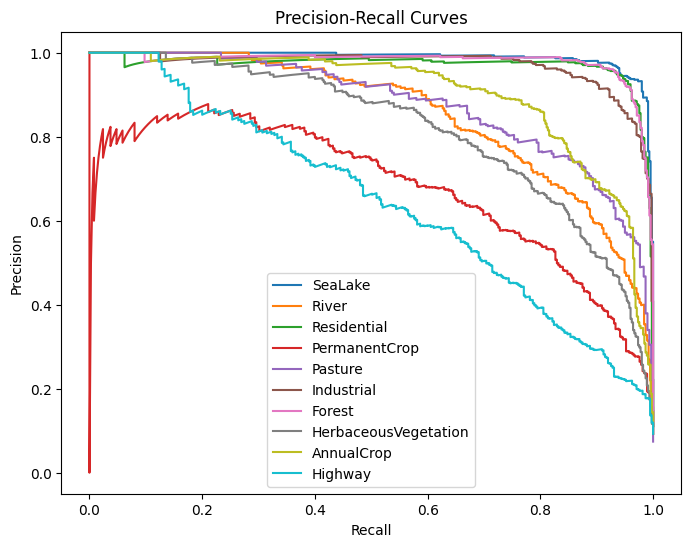

In [20]:

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, label=classes[i])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()
